In [2]:
import sklearn
import pandas as pd
import automated_ML as autoML # load custom python file containing relevant functions
from sklearn.datasets import fetch_california_housing # convenient dataset for continuous regression
import pprint # to neatly print dictionary results
from matplotlib import pyplot as plt

In [3]:
dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
y = pd.DataFrame(y_full)
X = pd.DataFrame(X_full)

## Perform Regression
Select a varied array of regressors optimized towards maximizing the $R^2$ score. For this example a dictionary with spline values is provided. Spline transformations of the $X$-matrix can helping predicting non-linear patterns. The regressors are optimized such that both with and without spline transformations are tested, i.e. even if a `spline_value` is provided, optimization may favour ignore any spline transformation. Alternatively you may suggest pca compression or a polynomial expension of the $X$ matrix by supply `pca_value` and `poly_value` with values. 

Runtime can vary greatly depending on the size of the dataset and the chosen regressors. Consider running it on a platform such as Spyder for which the terminal output does not overflow (as with Jupyter) 
   

In [5]:
input_dict = {
    'y': y,
    'X': X,
    'test_frac': 0.2,
    'timeout': 600,
    'n_trial': 50,
    'spline_value': {'n_knots': 5, 'degree':3},
    'metric_optimise': sklearn.metrics.r2_score,
    'metric_assess': [sklearn.metrics.mean_pinball_loss, sklearn.metrics.mean_squared_error, sklearn.metrics.r2_score],
    'optimisation_direction': 'maximize',
    'overwrite': True,
    'list_regressors_hyper': ['lightgbm', 'bayesianridge', 'histgradientboost', 'knn'],
    'random_state': 42,

}

metric_performance_summary_dict, idexes_test_kfold, test_index, train_index, y_pred, y_test = autoML.automated_regression(**input_dict)

[I 2023-01-19 10:36:45,866] A new study created in memory with name: no-name-ef249aeb-3e13-4d83-82e9-ec1cc3f29269
[I 2023-01-19 10:36:47,046] Trial 0 finished with value: 0.7400763496467656 and parameters: {'scalers': 'minmax', 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 2500, 'objective': 'regression', 'max_depth': 15, 'n_estimators': 53, 'max_bin': 63, 'min_gain_to_split': 4.563633644393066, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'num_leaves': 76, 'feature_fraction': 0.6506676052501416, 'bagging_fraction': 0.22554447458683766, 'bagging_freq': 3, 'min_child_samples': 37, 'random_state': 42, 'verbosity': -1}. Best is trial 0 with value: 0.7400763496467656.
[I 2023-01-19 10:36:47,607] Trial 1 finished with value: 0.7546404105169675 and parameters: {'scalers': 'minmax', 'feature_combo': False, 'transformers': 'none', 'objective': 'regression', 'max_depth': 4, 'n_estimators': 1656, 'max_bin': 63, 'min_gain_to_split': 6.60228740609

[I 2023-01-19 10:37:31,160] Trial 40 pruned. 
[I 2023-01-19 10:37:31,374] Trial 41 pruned. 
[I 2023-01-19 10:37:31,579] Trial 42 pruned. 
[I 2023-01-19 10:37:32,525] Trial 43 finished with value: 0.7781614035009315 and parameters: {'scalers': 'standard', 'feature_combo': False, 'transformers': 'none', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 192, 'max_bin': 127, 'min_gain_to_split': 7.287487249616412, 'lambda_l1': 2.5193167682128217, 'lambda_l2': 6.120083609691025, 'num_leaves': 256, 'feature_fraction': 0.4845175020418949, 'bagging_fraction': 0.9982141583273755, 'bagging_freq': 5, 'min_child_samples': 9, 'random_state': 42, 'verbosity': -1}. Best is trial 20 with value: 0.8420835067182686.
[I 2023-01-19 10:37:33,009] Trial 44 pruned. 
[I 2023-01-19 10:37:33,565] Trial 45 pruned. 
[I 2023-01-19 10:37:34,320] Trial 46 pruned. 
[I 2023-01-19 10:37:34,622] Trial 47 pruned. 
[I 2023-01-19 10:37:35,395] Trial 48 finished with value: 0.7788421269771424 and parameters: {'scal

[I 2023-01-19 10:37:59,054] Trial 39 pruned. 
[I 2023-01-19 10:38:00,121] Trial 40 pruned. 
[I 2023-01-19 10:38:01,191] Trial 41 finished with value: 0.5577974369913443 and parameters: {'scalers': None, 'feature_combo': True, 'pca_value': None, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 5, 'order': 'C'}, 'poly_value': None, 'transformers': 'none', 'n_iter': 44, 'tol': 25.12224400227543, 'alpha_1': 5.6528172166715894e-08, 'alpha_2': 0.02918877586004695, 'lambda_1': 1.0345512421529322e-06, 'lambda_2': 0.003844414192388415}. Best is trial 22 with value: 0.6598300574413295.
[I 2023-01-19 10:38:01,892] Trial 42 pruned. 
[I 2023-01-19 10:38:04,285] Trial 43 finished with value: 0.6598380366491416 and parameters: {'scalers': 'robust', 'feature_combo': True, 'pca_value': None, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 5, 'order': 'C'}, 'poly_value': None, '

[I 2023-01-19 10:42:41,312] Trial 34 pruned. 
[I 2023-01-19 10:43:12,845] Trial 35 pruned. 
[I 2023-01-19 10:43:16,504] Trial 36 pruned. 
[I 2023-01-19 10:43:21,990] Trial 37 pruned. 
[I 2023-01-19 10:43:36,486] Trial 38 finished with value: 0.8080226075712262 and parameters: {'scalers': 'standard', 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 2800, 'loss': 'absolute_error', 'max_depth': 16, 'max_iter': 235, 'max_leaf_nodes': 17, 'min_samples_leaf': 5, 'learning_rate': 0.14705097339373455, 'n_iter_no_change': 20, 'random_state': 42}. Best is trial 31 with value: 0.8431714565673374.
[I 2023-01-19 10:43:38,359] Trial 39 pruned. 
[I 2023-01-19 10:43:52,192] Trial 40 finished with value: 0.8116264072868624 and parameters: {'scalers': 'minmax', 'feature_combo': False, 'transformers': 'quantile_trans', 'n_quantiles': 400, 'loss': 'absolute_error', 'max_depth': 16, 'max_iter': 168, 'max_leaf_nodes': 26, 'min_samples_leaf': 55, 'learning_rate': 0.1185516450142959, '

[I 2023-01-19 10:46:37,632] Trial 30 finished with value: 0.7105563465840441 and parameters: {'scalers': 'minmax', 'feature_combo': False, 'transformers': 'none', 'n_neighbors': 6, 'weights': 'distance'}. Best is trial 10 with value: 0.7105563465840441.
[I 2023-01-19 10:46:37,984] Trial 31 pruned. 
[I 2023-01-19 10:46:45,175] Trial 32 finished with value: 0.702923508399009 and parameters: {'scalers': 'standard', 'feature_combo': True, 'pca_value': None, 'spline_value': {'degree': 3, 'extrapolation': 'constant', 'include_bias': True, 'knots': 'uniform', 'n_knots': 5, 'order': 'C'}, 'poly_value': None, 'transformers': 'quantile_trans', 'n_quantiles': 2300, 'n_neighbors': 26, 'weights': 'distance'}. Best is trial 10 with value: 0.7105563465840441.
[I 2023-01-19 10:46:45,305] Trial 33 pruned. 
[I 2023-01-19 10:46:46,058] Trial 34 finished with value: 0.7120765931631403 and parameters: {'scalers': 'minmax', 'feature_combo': False, 'transformers': 'none', 'n_neighbors': 16, 'weights': 'dista

Stacked Regressor already exists in directory. Overwrite set to 'TRUE'. Are you certain ? (y/n): y


In [6]:
pprint.pprint(metric_performance_summary_dict)

{'bayesianridge': [[0.23831448109469142, 0.0041932729745831985],
                   [0.48474797603508735, 0.025091062528403717],
                   [0.6287835161821794, 0.030277306322050564]],
 'histgradientboost': [[0.14666511039699098, 0.0059409976861288126],
                       [0.19750415335671972, 0.020842566429227365],
                       [0.8483939511736024, 0.020746745933146665]],
 'knn': [[0.19593254387154543, 0.003357353531940951],
         [0.3492703133584472, 0.014914276288515464],
         [0.7329469310496037, 0.014296476906733567]],
 'lightgbm': [[0.14854180247441728, 0.00677827283084609],
              [0.2000669841074934, 0.021625535288178684],
              [0.8463685656639613, 0.021522778951313618]],
 'stacked': [[0.14451022871291103, 0.006593597485213238],
             [0.19261113676109312, 0.02138425887743273],
             [0.8520927961202949, 0.021115371710017282]]}


Performance is best for the `stacked` regressor with the worst performance being the `bayesianridge` regressor. The best performing trials for `bayesianridge`, `KNN` and `histgradientboosting` makes use of a spline transformation (```python spline_value !=  None```) whereas `lightgbm` favors no such transformation

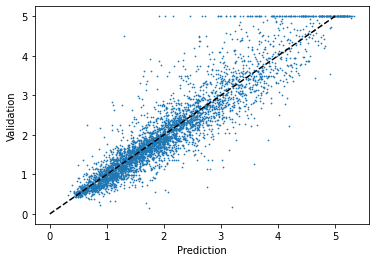

In [7]:
plt.scatter(y_pred, y_test, s = 0.5); plt.plot([0,5], [0,5], '--k'); 
plt.xlabel("Prediction"); _ = plt.ylabel("Validation") 